#**EPiC: Ensemble of Partial Point Clouds for Robust Classification**



## Preprocessing

In [2]:
! git clone https://github.com/yossilevii100/EPiC.git
%cd EPiC

Cloning into 'EPiC'...
remote: Enumerating objects: 291, done.
remote: Counting objects: 100% (291/291), done.
remote: Compressing objects: 100% (228/228), done.
remote: Total 291 (delta 96), reused 239 (delta 44), pack-reused 0
Receiving objects: 100% (291/291), 3.88 MiB | 7.93 MiB/s, done.
Resolving deltas: 100% (96/96), done.
/content/EPiC


In [5]:
# Be patient, this installation might take some time (~7.5 minutes)
! pip install pointnet2_ops_lib/.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./pointnet2_ops_lib
  Preparing metadata (setup.py) ... done
  Created wheel for pointnet2-ops: filename=pointnet2_ops-3.0.0-cp39-cp39-linux_x86_64.whl size=10695261 sha256=c7a0e933e21e2a6fe3f3f6171c296ce154069fe3b4c6fbf24f60ef1938a34148
  Stored in directory: /tmp/pip-ephem-wheel-cache-c0zuhhsj/wheels/9f/f0/eb/18276a6d5659b75822d203e63c8fa719e5e1fb4b3109109ace
Successfully built pointnet2-ops


#### Data (ModelNet-C)

In [ ]:
%cd data
! gdown https://drive.google.com/uc?id=1KE6MmXMtfu_mgxg4qLPdEwVD5As8B0rm
! unzip modelnet_c.zip 
%cd ..

#### Pretrained Models

In [ ]:
! gdown https://drive.google.com/uc?id=15Q-YewNGvte8PmteVjTmqE0vzDL3ViJd
! unzip pretrained.zip -d pretrained

##Reevaluate Results

Now you can choose one of the following optional models to run.

Un-augmented:

`python main.py --model dgcnn --eval`

`python main.py --model curvenet --eval`

`python main.py --model rpc --eval`

`python main.py --model pct --eval`

`python main.py --model gdanet --eval`

WolfMix Augmented:

`python main.py --model dgcnn --eval --use_wolfmix`

`python main.py --model curvenet --eval --use_wolfmix`

`python main.py --model rpc --eval --use_wolfmix`

`python main.py --model pct --eval --use_wolfmix`

`python main.py --model gdanet --eval --use_wolfmix`


#### ModelNet-C SOTA

In [ ]:
! python main.py --model rpc --eval --use_wolfmix

Namespace(eval=True, exp_name='my_experiment', model='rpc', batch_size=64, test_batch_size=64, epochs=500, lr=0.005, momentum=0.9, no_cuda=False, seed=1, num_points=1024, dropout=0.3, emb_dims=1024, k=20, nc=512, np=512, nr=128, m=20, k_tilde=4, train_random=False, train_patches=False, train_curves=False, model_path_patches='', model_path_random='', model_path_curves='', use_wolfmix=True, rdscale=False, shift=False, shuffle=False, rot=False, jitter=False, rddrop=False, rsmix_prob=0.5, beta=1.0, nsample=512, normal=False, knn=False, w_num_anchor=4, w_sample_type='fps', w_sigma=0.5, w_R_range=10, w_S_range=3, w_T_range=0.25)
Using GPU : 0 from 1 devices
/content/EPiC/models/gdanet/GDANet_util.py:178: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(self.W[1].weight, 0)
/content/EPiC/models/gdanet/GDANet_util.py:179: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(self.W[1].bias, 0)
{'acc': 

As you can see, RPC trained with WolfMix augmentation achieves SOTA: mCE = 0.501.

Now, Let's dive into the debug. We want to examine the network's response to various cases. Let's focus on DGCNN.

First, let's load the architecture and some auxiliary functions:

#### Debugging Example

In [8]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


LABELS = [
    'airplane', 'bathtub', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl', 'car',
    'chair', 'cone', 'cup', 'curtain', 'desk', 'door', 'dresser', 'flower_pot',
    'glass_box', 'guitar', 'keyboard', 'lamp', 'laptop', 'mantel', 'monitor',
    'night_stand', 'person', 'piano', 'plant', 'radio', 'range_hood', 'sink',
    'sofa', 'stairs', 'stool', 'table', 'tent', 'toilet', 'tv_stand', 'vase',
    'wardrobe', 'xbox'
]

def get_knn(x, k):
    inner = -2 * torch.matmul(x.transpose(2, 1), x)
    xx = torch.sum(x ** 2, dim=1, keepdim=True)
    pairwise_distance = -xx - inner - xx.transpose(2, 1)
    distances, indices = torch.sort(pairwise_distance, dim=-1, descending=True)

    k_indices = indices[:, :, :k]
    k_indices = k_indices.to(torch.int64)
    k_distances = distances[:, :, :k]
    return k_indices, k_distances


def extract_patches(pc, anchor, patch_size):
    # extract patch starting from anchor with a size of patch_size
    # input -
    # pc: Bx3xN
    # anchor: Bx1
    # patch_size: int
    # output -
    # patch: Bx3xK -> K is min(patch_size, N)

    B, num_dims, N = pc.shape

    # in case patch_size is larger than N, the entire point-cloud is considered as the patch
    actual_patch_size = min(patch_size, N)
    pc_neighbors, _ = get_knn(x=pc, k=actual_patch_size)

    anchor = anchor.unsqueeze(-1).repeat(1, 1, actual_patch_size)
    anchor_neighbors = torch.gather(pc_neighbors, 1, anchor).squeeze(1)

    indices_base = torch.arange(0, B, device=pc.device).view(-1, 1) * N  # Bx1

    anchor_neighbors = anchor_neighbors + indices_base
    anchor_neighbors = anchor_neighbors.view(-1)

    # Fetch the patch indices from the point cloud
    patch = pc.transpose(2, 1).contiguous()  # (B,N,num_dims)->(B*N,num_dims) :B*N*k+range(0,B*N)
    patch = patch.view(B * N, -1)[anchor_neighbors, :]
    patch = patch.view(B, actual_patch_size, num_dims)
    patch = patch.transpose(1, 2)  # Bx3XK

    return patch


def extract_random(pc: torch.Tensor, k: int) -> torch.Tensor:
    """Extracts K random points from point-cloud
    Parameters:
    pc (torch.Tensor): (B,3,N) point cloud
    k (int): number of random points to be fetched

    Returns:
    random_ppc (torch.Tensor): (B,3,K) random fetched point-cloud

   """
    # choose K random indices
    indices = torch.randperm(pc.shape[-1])
    random_indices = indices[:k]

    # Fetch the random indices from the point cloud
    random_ppc = pc[:, :, random_indices]
    return random_ppc


def extract_curves(pc, anchor, m, curve_size):
    # extract curve starting from anchor with a size of curve_size, at each iteration choose randomly one of m nearest neighbors
    # input -
    # pc: Bx3xN
    # anchor: Bx1
    # m: int -> number of neighbors to choose from
    # curve_size: int
    # output -
    # curve: Bx3xK

    B, num_dims, N = pc.shape
    actual_curve_size = min(curve_size, N)

    neighbors_indices, _ = get_knn(pc, m)

    # exclude self-loop
    neighbors_indices = neighbors_indices[:, :, 1:]
    m = m - 1

    # generate neighbors mask - to choose from at each iteration
    neighbors_ones = torch.ones_like(neighbors_indices)
    neighbors_mask = torch.zeros((B, N, N), device=pc.device).to(neighbors_ones.dtype)
    neighbors_mask = neighbors_mask.scatter_(-1, neighbors_indices, neighbors_ones)

    anchor_for_gather = anchor.unsqueeze(-1).repeat(1, 3, 1)
    curve = torch.gather(pc, 2, anchor_for_gather)

    cur_point = anchor.squeeze(-1)
    for step in range(actual_curve_size - 1):
        # choose random index
        random_indices = torch.randperm(m)
        random_neighbor_index = random_indices[0]

        # Fetch the actual point in the random index
        cur_point = cur_point.view(-1, 1, 1).repeat(1, 1, N)
        neighbors_list = torch.gather(neighbors_mask, index=cur_point, dim=1)
        neighbors = torch.nonzero(neighbors_list, as_tuple=True)[2]
        neighbors = neighbors.view(B, m)
        chosen_neighbor = neighbors[:, random_neighbor_index]  # B,

        chosen_neighbor_for_gather = chosen_neighbor.view(-1, 1, 1).repeat(1, 3, 1)
        neighbor_point = torch.gather(pc, index=chosen_neighbor_for_gather, dim=2)

        # concatenate to the accumulative curve
        curve = torch.cat((curve, neighbor_point), dim=-1)
        cur_point = chosen_neighbor
    return curve

def load_h5(h5_name):
    import h5py
    f = h5py.File(h5_name, 'r')
    data = f['data'][:].astype('float32')
    label = f['label'][:].astype('int64')
    f.close()
    return data, label

def farthest_point_sample(xyz, npoint):
    """
    Input:
        xyz: pointcloud data, [B, N, 3]
        npoint: number of samples
    Return:
        centroids: sampled pointcloud index, [B, npoint]
    """
    device = xyz.device
    B, N, C = xyz.shape
    centroids = torch.zeros(B, npoint, dtype=torch.long).to(device)
    distance = torch.ones(B, N).to(device) * 1e10
    farthest = torch.randint(0, N, (B,), dtype=torch.long).to(device) * 0
    batch_indices = torch.arange(B, dtype=torch.long).to(device)
    for i in range(npoint):
        centroids[:, i] = farthest
        centroid = xyz[batch_indices, farthest, :].view(B, 1, 3)
        dist = torch.sum((xyz - centroid) ** 2, -1)
        mask = dist < distance
        distance[mask] = dist[mask]
        farthest = torch.max(distance, -1)[1]
    return centroids

def knn(x, k):
    inner = -2*torch.matmul(x.transpose(2, 1), x)
    xx = torch.sum(x**2, dim=1, keepdim=True)
    pairwise_distance = -xx - inner - xx.transpose(2, 1)    
    _, indices = torch.sort(pairwise_distance, dim=-1, descending=True)
    idx = indices[:,:,:k]
    idx = idx.to(torch.int64)
    
    return idx

def get_graph_feature(x, k=20, idx=None):
    batch_size = x.size(0)
    num_points = x.size(2)
    x = x.view(batch_size, -1, num_points)
    if idx is None:
        idx = knn(x, k=k)   # (batch_size, num_points, k)
    device = torch.device('cuda')

    idx_base = torch.arange(0, batch_size, device=device).view(-1, 1, 1)*num_points

    idx = idx + idx_base

    idx = idx.view(-1)
 
    _, num_dims, _ = x.size()

    x = x.transpose(2, 1).contiguous()   # (batch_size, num_points, num_dims)  -> (batch_size*num_points, num_dims) #   batch_size * num_points * k + range(0, batch_size*num_points)
    feature = x.view(batch_size*num_points, -1)[idx, :]
    feature = feature.view(batch_size, num_points, k, num_dims) 
    x = x.view(batch_size, num_points, 1, num_dims).repeat(1, 1, k, 1)
    
    feature = torch.cat((feature-x, x), dim=3).permute(0, 3, 1, 2).contiguous()
  
    return feature

class DGCNN(nn.Module):
    def __init__(self, args, output_channels=40):
        super(DGCNN, self).__init__()
        self.args = args
        self.k = args.k
        
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm1d(args.emb_dims)

        self.conv1 = nn.Sequential(nn.Conv2d(6, 64, kernel_size=1, bias=False),
                                   self.bn1,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv2 = nn.Sequential(nn.Conv2d(64*2, 64, kernel_size=1, bias=False),
                                   self.bn2,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv3 = nn.Sequential(nn.Conv2d(64*2, 128, kernel_size=1, bias=False),
                                   self.bn3,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv4 = nn.Sequential(nn.Conv2d(128*2, 256, kernel_size=1, bias=False),
                                   self.bn4,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv5 = nn.Sequential(nn.Conv1d(512, args.emb_dims, kernel_size=1, bias=False),
                                   self.bn5,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.linear1 = nn.Linear(args.emb_dims*2, 512, bias=False)
        self.bn6 = nn.BatchNorm1d(512)
        self.dp1 = nn.Dropout(p=args.dropout)
        self.linear2 = nn.Linear(512, 256)
        self.bn7 = nn.BatchNorm1d(256)
        self.dp2 = nn.Dropout(p=args.dropout)
        self.linear3 = nn.Linear(256, output_channels)

    def forward(self, x):
        batch_size = x.size(0)
        x = get_graph_feature(x, k=self.k)
        x = self.conv1(x)
        x1 = x.max(dim=-1, keepdim=False)[0]

        x = get_graph_feature(x1, k=self.k)
        x = self.conv2(x)
        x2 = x.max(dim=-1, keepdim=False)[0]

        x = get_graph_feature(x2, k=self.k)
        x = self.conv3(x)
        x3 = x.max(dim=-1, keepdim=False)[0]

        x = get_graph_feature(x3, k=self.k)
        x = self.conv4(x)
        x4 = x.max(dim=-1, keepdim=False)[0]

        x = torch.cat((x1, x2, x3, x4), dim=1)

        x = self.conv5(x)
        x1 = F.adaptive_max_pool1d(x, 1).view(batch_size, -1)
        x2 = F.adaptive_avg_pool1d(x, 1).view(batch_size, -1)
        x = torch.cat((x1, x2), 1)

        x = F.leaky_relu(self.bn6(self.linear1(x)), negative_slope=0.2)
        x = self.dp1(x)
        x = F.leaky_relu(self.bn7(self.linear2(x)), negative_slope=0.2)
        x = self.dp2(x)
        x = self.linear3(x)
        return x

def visualize_pc(pc, ppc, ax):
    # pc: 1x3xN
    # ppc: 1x3xK
    pc, ppc = pc[0,:].transpose(0,1), ppc[0,:].transpose(0,1)
    for ii, point in enumerate(pc):
        # point: 3,
        exist_in_ppc = torch.any(torch.sum(ppc==point,1)==3)
        if exist_in_ppc:
            m_color = 'red'
        elif ii>1023:
            m_color = 'grey'
        else:
            m_color = 'green'
        point = point.detach().cpu().numpy()
        ax.scatter(point[0],   # x
                  point[1],   # y
                  point[2],   # z
                  c=m_color,
                  marker="o",
                  linewidth=0.5)
        
def plot_ppcs(cur_data, cur_label, preds, ppcs, ppcs_str):
    for ii, (pred,ppc) in enumerate(zip(preds, ppcs)):
        fig = plt.figure(figsize=(12,3))
        if ii==0:
            fig.suptitle(f'{LABELS[cur_label]}-{ppcs_str}')
        ax0 = fig.add_subplot(1, 2, 1, projection='3d')
        ax0.view_init(0, 90)
        visualize_pc(cur_data, ppc, ax0)
        ax1 = fig.add_subplot(1, 2, 2)
        pred_class = torch.argmax(pred[0,:])
        if pred_class==cur_label:
            plt.bar(range(40), pred[0,:].detach().cpu().numpy(), color ='g')
        else:
            plt.bar(range(40), pred[0,:].detach().cpu().numpy(), color ='r')
        ax1.title(f'prediction: {LABELS[pred_class]}')
        plt.show()

Now let's load the learned parameters to the 3 networks specialized in curves, patches and random.

In [9]:
import argparse
parser = argparse.ArgumentParser(
    description='EPiC: Ensemble of partial Point Clouds for robust classification - Official Implementation')
# Training and testing parameters
parser.add_argument('--eval', action='store_true',
                    help='evaluate the model if True, otherwise train')
parser.add_argument('--exp_name', type=str, default='my_experiment', metavar='N',
                    help='Name of the experiment')
parser.add_argument('--model', type=str, default='dgcnn', metavar='N',
                    choices=['curvenet', 'dgcnn', 'dgcnn_v1', 'dgcnn_v2', 'dgcnn_v3', 'dgcnn_v5', 'gdanet', 'rpc',
                              'pct', 'custom_model'],
                    help='Model Architecture to use as a basic model for random, patches and curves')
parser.add_argument('--batch_size', type=int, default=64, metavar='batch_size',
                    help='Size of batch)')
parser.add_argument('--test_batch_size', type=int, default=64, metavar='batch_size',
                    help='Size of batch)')
parser.add_argument('--epochs', type=int, default=500, metavar='N',
                    help='number of episode to train ')
parser.add_argument('--lr', type=float, default=0.005, metavar='LR',
                    help='learning rate (default: 0.001, 0.1 if using sgd)')
parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                    help='SGD momentum (default: 0.9)')
parser.add_argument('--no_cuda', type=bool, default=False,
                    help='enables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--num_points', type=int, default=1024,
                    help='num of points to use')

# Architectures parameters
parser.add_argument('--dropout', type=float, default=0.3,
                    help='dropout rate')
parser.add_argument('--emb_dims', type=int, default=1024, metavar='N',
                    help='Dimension of embeddings')
parser.add_argument('--k', type=int, default=20, metavar='N',
                    help='Num of nearest neighbors to use')

# EPiC parameters
parser.add_argument('--nc', type=int, default=512, metavar='N',
                    help='number of points per curve')
parser.add_argument('--np', type=int, default=512, metavar='N',
                    help='number of points per patch')
parser.add_argument('--nr', type=int, default=128, metavar='N',
                    help='number of points per random')
parser.add_argument('--m', type=int, default=20, metavar='N',
                    help='number of neighbors for curve random picking')
parser.add_argument('--k_tilde', type=int, default=4,
                    help='number of anchor points in the shape')
parser.add_argument('--train_random', action='store_true',
                    help='enable for random ppc training')
parser.add_argument('--train_patches', action='store_true',
                    help='enable for patches ppc training')
parser.add_argument('--train_curves', action='store_true',
                    help='enable for curves ppc training')

parser.add_argument('--model_path_patches', type=str, default='', metavar='N',
                    help='Pretrained model path for patches testing')
parser.add_argument('--model_path_random', type=str, default='', metavar='N',
                    help='Pretrained model path for random testing')
parser.add_argument('--model_path_curves', type=str, default='', metavar='N',
                    help='Pretrained model path for curves testing')

# Augmentations parameters
parser.add_argument('--use_wolfmix', action='store_true', help='if to apply augmentation')
# rsmix
parser.add_argument('--rdscale', action='store_true', help='random scaling data augmentation')
parser.add_argument('--shift', action='store_true', help='random shift data augmentation')
parser.add_argument('--shuffle', action='store_true', help='random shuffle data augmentation')
parser.add_argument('--rot', action='store_true', help='random rotation augmentation')
parser.add_argument('--jitter', action='store_true', help='jitter augmentation')
parser.add_argument('--rddrop', action='store_true', help='random point drop data augmentation')
parser.add_argument('--rsmix_prob', type=float, default=0.5, help='rsmix probability')
parser.add_argument('--beta', type=float, default=1.0, help='scalar value for beta function')
parser.add_argument('--nsample', type=float, default=512,
                    help='default max sample number of the erased or added points in rsmix')
parser.add_argument('--normal', action='store_true', help='use normal')
parser.add_argument('--knn', action='store_true', help='use knn instead ball-query function')

# pointwolf
parser.add_argument('--w_num_anchor', type=int, default=4, help='Num of anchor point')
parser.add_argument('--w_sample_type', type=str, default='fps',
                    help='Sampling method for anchor point, option : (fps, random)')
parser.add_argument('--w_sigma', type=float, default=0.5, help='Kernel bandwidth')

parser.add_argument('--w_R_range', type=float, default=10, help='Maximum rotation range of local transformation')
parser.add_argument('--w_S_range', type=float, default=3, help='Maximum scailing range of local transformation')
parser.add_argument('--w_T_range', type=float, default=0.25,
                    help='Maximum translation range of local transformation')

args, unknown = parser.parse_known_args()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load model patches
model_patches = DGCNN(args).to(device)
model_path_patches = os.path.join('pretrained','dgcnn_patches.t7')
checkpoint = torch.load(model_path_patches, map_location='cpu')
model_patches.load_state_dict(checkpoint)

# load model curves
model_curves = DGCNN(args).to(device)
model_path_curves = os.path.join('pretrained','dgcnn_curves.t7')
checkpoint = torch.load(model_path_curves, map_location='cpu')
model_curves.load_state_dict(checkpoint)

# load model random
model_random = DGCNN(args).to(device)
model_path_random = os.path.join('pretrained','dgcnn_random.t7')
checkpoint = torch.load(model_path_random, map_location='cpu')
model_random.load_state_dict(checkpoint)

<All keys matched successfully>

Let's run EPiC. You may choose the corruption, severity and the index to be examined.

In [10]:
import os
# Choose corruption out of the following: ['add_global', 'add_local', 'dropout_global', 'dropout_local', 'jitter', 'scale', 'rotate']
corruption = 'add_global' 
# Choose severity out of the following: [0,1,2,3,4]
severity = 4
# Choose random sample out of the following: [0..2468]
random_sample = 345


DATA_DIR = os.path.join('data', 'modelnet_c')
h5_path = os.path.join(DATA_DIR, f'{corruption}_{severity}.h5')
data, label = load_h5(h5_path)
data = torch.from_numpy(data)
label = torch.from_numpy(label)
data = data.permute(0, 2, 1)  #B,3,N
cur_data, cur_label = data[[random_sample],:].to(device), label[random_sample,:].to(device)

anchors = farthest_point_sample(cur_data.transpose(1, 2), args.k_tilde)
model_patches.eval()
model_curves.eval()
model_random.eval()
patches_preds = []
patches_ppcs = []
curves_preds = []
curves_ppcs = []
random_preds = []
random_ppcs = []
for cur_ppc in range(args.k_tilde):
    random_ppc = extract_random(cur_data, args.nr)  # B,3,nr Global partial point-cloud
    
    patches_ppc = extract_patches(cur_data, anchors[:, [cur_ppc]],
                                  args.np)  # B,3,np Local partial point-cloud
    curves_ppc = extract_curves(cur_data, anchors[:, [cur_ppc]], args.m,
                                args.nc)  # B,3,nc Local partial point-cloud
    random_ppc = random_ppc.to(device)
    patches_ppc = patches_ppc.to(device)
    curves_ppc = curves_ppc.to(device)

    logits_random = model_random(random_ppc)
    logits_patches = model_patches(patches_ppc)
    logits_curves = model_curves(curves_ppc)

    curves_preds.append(logits_curves)
    patches_preds.append(logits_patches)
    random_preds.append(logits_random)

    patches_ppcs.append(patches_ppc)
    curves_ppcs.append(curves_ppc)
    random_ppcs.append(random_ppc)


RuntimeError: ignored

Let's take deeper look at the results. We are going to plot the various partial-point-clouds fetched out of the point-cloud.

The visualization contains the fetched point-cloud and the corresponding prediction. Correct prediction colored in green and misclassified in red.
Point-cloud is colored as followes:

Red - part of the sub-sample.

Grey - corrupted added points.

Green - part of the point-cloud that were not selected in the sub-sampling process.


In [1]:
# plot patches
plot_ppcs(cur_data, cur_label, patches_preds, patches_ppcs, 'Patches')

NameError: ignored

Patches have access to the full resolution of the features in the data, therefore yields good results on the clean set but tends to select also the added corrupted points, leading to misclassifications in most cases under this corruption.

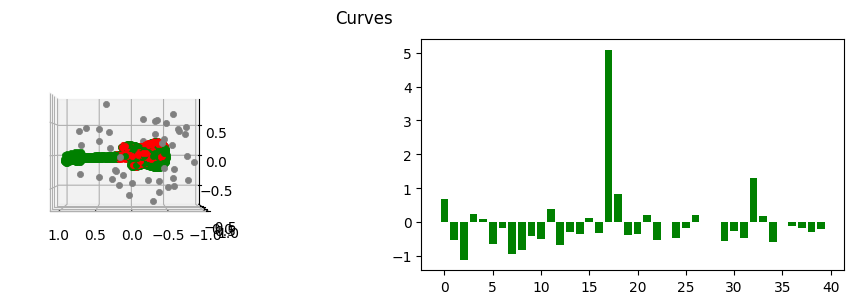

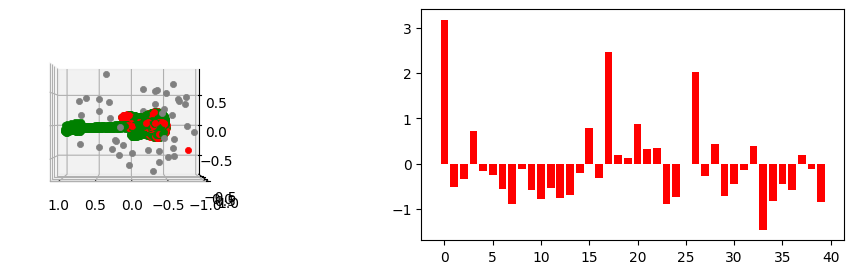

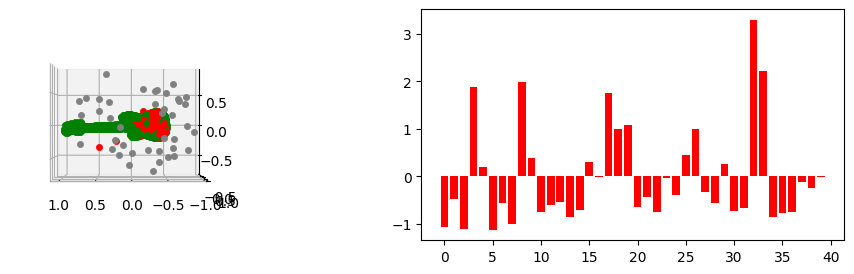

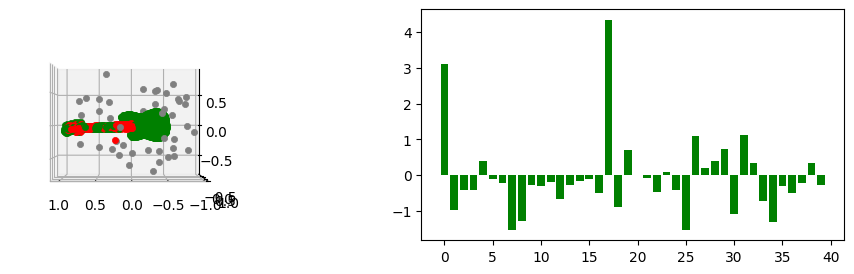

In [ ]:
# plot curves
plot_ppcs(cur_data, cur_label, curves_preds, curves_ppcs, 'Curves')

Because curves are not tend to select regions with low conductance, as long as the selected anchor point is not corrupted one, the curve is most likely to not be exposed to the corruption at all yielding 'clean' partial-point-cloud. These clean curves achieves correct and certain predictions.

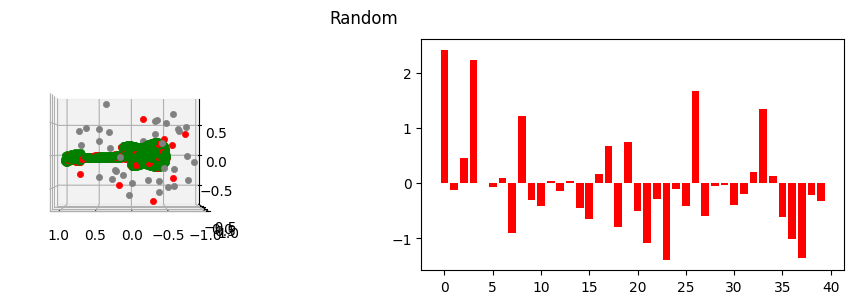

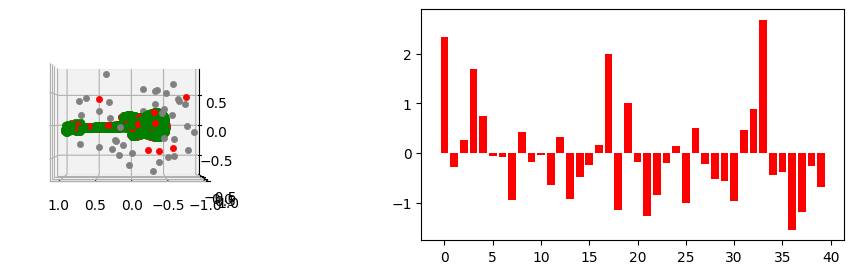

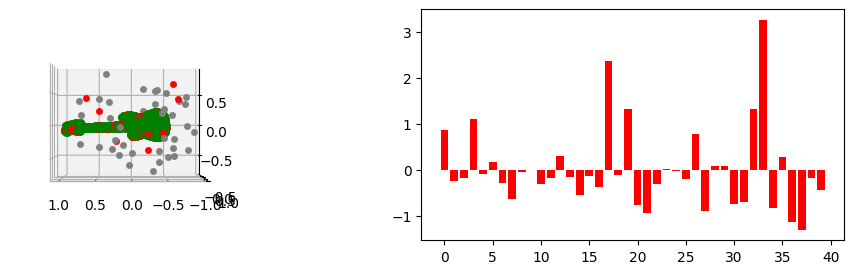

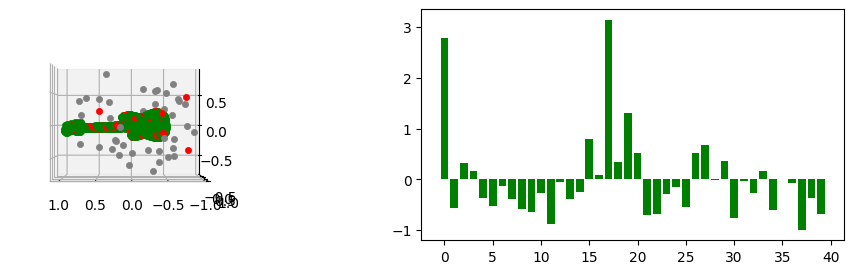

In [ ]:
# plot random
plot_ppcs(cur_data, cur_label, random_preds, random_ppcs, 'Random')

Random may select and may not select the corrupted points. Let's look how does the ensemble combined together with a simple mean!

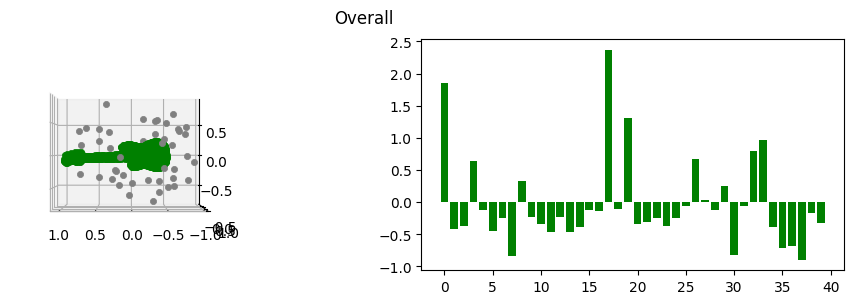

In [ ]:
# plot Overall

preds = patches_preds + curves_preds + random_preds
preds = [p.unsqueeze(0) for p in preds]
preds = torch.cat(preds, dim=0)
overall_pred = torch.mean(preds, dim=0)

dummy_ppc = torch.tensor([[-2,-2,-2],[-2,-2,-2]]).reshape(1,-1,2).to(cur_data.device)
plot_ppcs(cur_data, cur_label, [overall_pred], [dummy_ppc], 'Overall')

The prediction is correct, and relatively certain in the prediction although extreme outliers introduced.
When the partial-point-cloud is exposed to the corruption, the prediction can be modeled roughly as a noise, but when the partial-point-cloud is less exposed to the corruption, the prediction is more accurate and consistent. Therefore, simple mean over the predictions is diminishing the noisy predictions, overruled by the correct predictions.

Now you can try EPiC by yourself on various instances, corruptions and severities.
You can even insert your own point-cloud and examine it.

Have Fun!